<a href="https://colab.research.google.com/github/KrishnaPavaniMunta/Professional-Project/blob/main/Advanced_Learning_Model_for_MA_ipynb_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import and Installation**
Installing and ikmorting dependencies


In [ ]:
!pip install mne
!pip install mne-bids
import os
import numpy as np
import mne
from mne_bids import BIDSPath
!pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import gamma as gamma_function
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm
import numpy as np
from scipy.special import gamma as gamma_function
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm
import mne
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm
import os



**Generation of Synthetic Data**

The synthetic data is generated by combining the motion artifacts, restinf state noise and clean data. Later, preprocessing is done to fit the data into the model.

In [ ]:
def simulate_fnirs_data(duration=200, n_samples=23238, num_channels=56):
    t = np.linspace(0, duration, n_samples)

    def generate_resting_state_noise():
        np.random.seed(0)
        resting_state_data = np.random.randn(n_samples)
        ar_model = AutoReg(resting_state_data, lags=5)
        ar_model_fitted = ar_model.fit()
        params = ar_model_fitted.params
        arima_model = sm.tsa.ARIMA(endog=resting_state_data, order=(5, 0, 0))
        params_variance = arima_model.fit().params[-1]
        params = np.concatenate([params, [params_variance]])
        resting_state_noise = arima_model.simulate(params=params, nsimulations=n_samples)
        return resting_state_noise

    def add_spike_noise(t, num_spikes, peak_amplitude, scale_param):
        spike_noise = np.zeros_like(t)
        for _ in range(num_spikes):
            t0 = np.random.choice(t)
            spike = peak_amplitude * np.exp(-np.abs(t - t0) / scale_param)
            spike_noise += spike
        return spike_noise

    def add_shift_noise(t, num_shifts, amplitude_range):
        shift_noise = np.zeros_like(t)
        for _ in range(num_shifts):
            shift_time = np.random.choice(t)
            shift_amplitude = np.random.uniform(*amplitude_range)
            shift_noise[t >= shift_time] += shift_amplitude
        return shift_noise

    def generate_motion_artifacts(t):
        num_spikes = 10
        peak_amplitude = 500
        scale_param = 1
        num_shifts = 10
        amplitude_range = (-1000, 1000)
        spike_noise = add_spike_noise(t, num_spikes, peak_amplitude, scale_param)
        shift_noise = add_shift_noise(t, num_shifts, amplitude_range)
        motion_artifacts = spike_noise + shift_noise
        return motion_artifacts

    def gamma_hrf(t, peak, scale=1):
        t = np.maximum(t, 1e-10)  # Avoid division by zero
        return (t ** (peak - 1)) * np.exp(-t / scale) / (gamma_function(peak) * scale ** peak)

    def generate_evoked_responses(t, event_times):
        time_to_peak = 7
        scale = 3
        partial_volume_correction_factor = 50
        amplitudes = np.random.uniform(30, 80, 100) / partial_volume_correction_factor
        hrf_hbo = np.zeros_like(t)
        for event_time in event_times:
            hrf_event = np.zeros_like(t)
            for amplitude in amplitudes:
                hrf = amplitude * gamma_hrf(t - event_time, time_to_peak, scale)
                hrf[t < event_time] = 0
                hrf_event += hrf
            hrf_event /= np.max(hrf_event)
            hrf_event *= 50
            hrf_hbo += hrf_event
        return hrf_hbo

    resting_state_noise = np.array([generate_resting_state_noise() for _ in range(num_channels)])
    motion_artifacts = np.array([generate_motion_artifacts(t) for _ in range(num_channels)])
    event_times = np.arange(0, duration, 50)
    hrf_hbo = np.array([generate_evoked_responses(t, event_times) for _ in range(num_channels)])
    combined_signal = resting_state_noise + motion_artifacts + hrf_hbo

    return hrf_hbo, combined_signal

# Load the real data
fnirs_data_folder = mne.datasets.fnirs_motor.data_path()
fnirs_cw_amplitude_dir = fnirs_data_folder / "Participant-1"
raw_intensity = mne.io.read_raw_nirx(fnirs_cw_amplitude_dir, verbose=True)
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
# Convert to haemoglobin concentration
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od)
raw_numpy = raw_haemo.get_data()
# Selecting the first 50 rows
Clean_data = raw_numpy[:50, :20000]

# Simulate the data
duration = raw_intensity.times[-1] - raw_intensity.times[0]
n_samples = len(raw_intensity.times)
num_channels = raw_intensity.info['nchan']

hrf_hbo, simulated_signal = simulate_fnirs_data(duration, n_samples, num_channels)

simulated_signal = simulated_signal[:50, :20000]

# Add the simulated data to the real data
noisy_data = Clean_data + simulated_signal





Loading /root/mne_data/MNE-fNIRS-motor-data/Participant-1
Reading 0 ... 23238  =      0.000 ...  2974.464 secs...


KeyboardInterrupt: 

In [ ]:
def count_motion_artifacts(signal, threshold=1000):
    """
    Count the number of motion artifacts in the signal based on a threshold.
    """
    # Calculate the absolute value of the signal to detect spikes
    abs_signal = np.abs(signal)

    # Count the number of times the signal exceeds the threshold
    artifact_count = np.sum(abs_signal > threshold)

    return artifact_count

# Define the threshold based on your expected artifact size
threshold = 1000

# Count artifacts for each channel
artifact_counts = np.apply_along_axis(lambda x: count_motion_artifacts(x, threshold), axis=1, arr=simulated_signal)

# Print or visualize the results
print(f"Artifact counts per channel: {artifact_counts}")

Artifact counts per channel: [17795   167    28  5123   974  2917     0  8785 11001  8806    51  6960
  9398  2097  9135  4591 13007 15318    16 15590     0  1084 11393   807
  7271 13094 10729  9961     1  7672     0   170  6847 17753 15304 11464
  8183   764  4245 12048  6244 16259 12289  4486     0 13158  6809  4668
 14502 14451]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20000, 32)         128       
                                                                 
 batch_normalization (Batch  (None, 20000, 32)         128       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 10000, 32)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 10000, 64)         6208      
                                                                 
 batch_normalization_1 (Bat  (None, 10000, 64)         256       
 chNormalization)                                                
                                                        

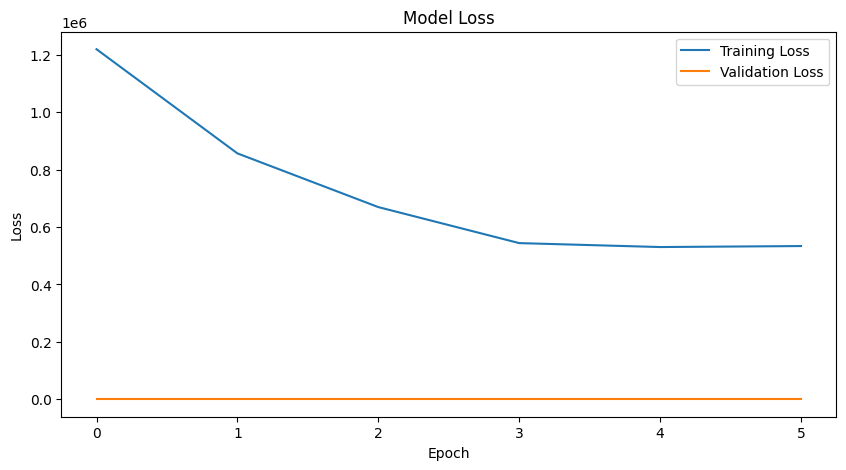

1/1 [==============================] - 4s 4s/step


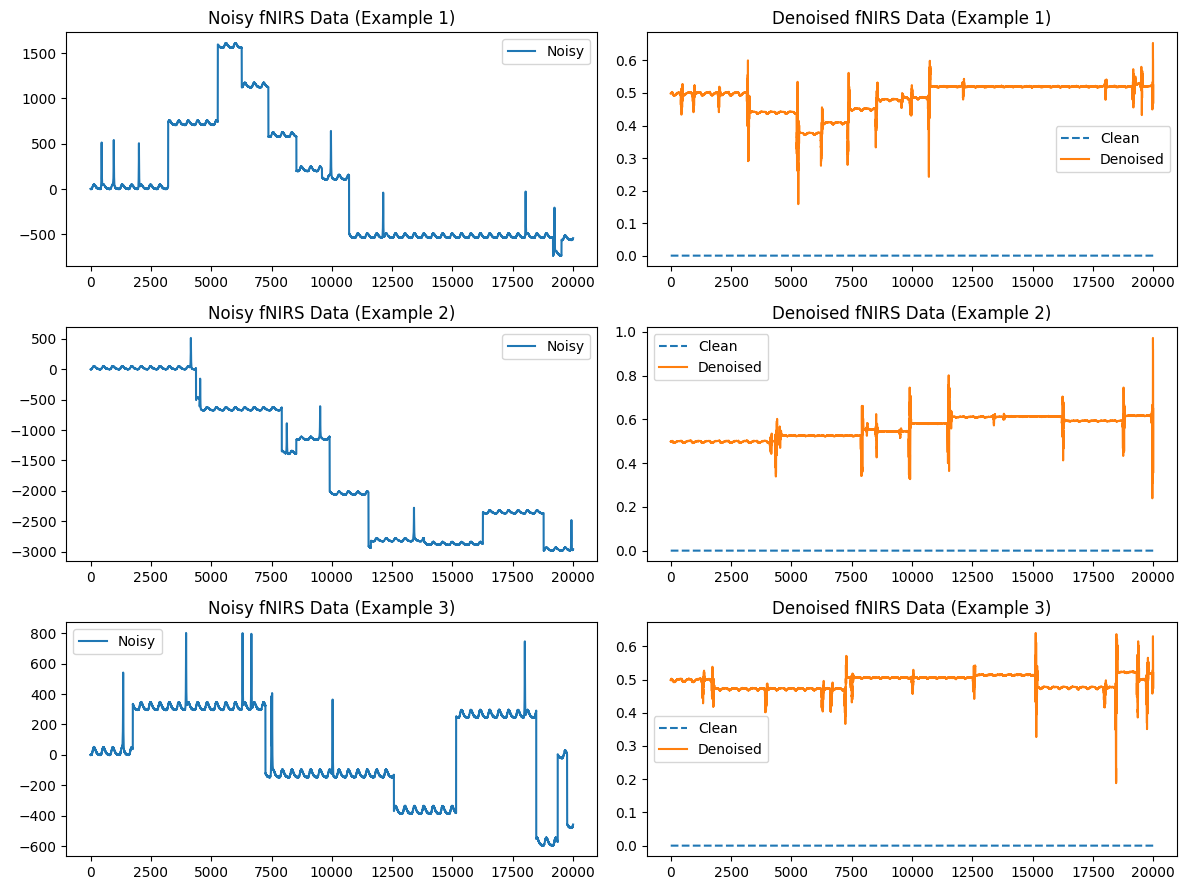

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import time



clean_hrf_2d, noisy_hrf_2d = Clean_data, noisy_data

# Reshape the data
X = noisy_hrf_2d[..., np.newaxis]
Y = clean_hrf_2d[..., np.newaxis]

# Split the data
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define DAE Model with enhancements
def create_dae_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv1D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01), input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2, padding='same'))


    model.add(layers.Conv1D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2, padding='same'))


    model.add(layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2, padding='same'))


    model.add(layers.Conv1D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2, padding='same'))


    model.add(layers.Conv1D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.UpSampling1D(2))


    model.add(layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.UpSampling1D(2))


    model.add(layers.Conv1D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.UpSampling1D(2))


    model.add(layers.Conv1D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.UpSampling1D(2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv1D(1, 3, activation='sigmoid', padding='same'))
    model.add(layers.Dropout(0.3))
    return model

# Custom Loss Functions
def mse_loss(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

def total_variation_loss(y_pred):
    return K.mean(K.square(y_pred - K.mean(y_pred)))

def std_loss(y_pred, m, N_std):
    diffs = y_pred[:, :-1] - y_pred[:, 1:]
    std_diffs = K.std(diffs, axis=-1)
    mask = K.greater(std_diffs, m)
    return K.sum(K.switch(mask, std_diffs, K.zeros_like(std_diffs))) / N_std

def amp_loss(y_pred, C_amp, N_amp):
    diffs = y_pred[:, :-1] - y_pred[:, 1:]
    amp_diffs = K.abs(diffs)
    mask = K.greater(amp_diffs, C_amp)
    return K.sum(K.switch(mask, amp_diffs, K.zeros_like(amp_diffs))) / N_amp

def combined_loss(y_true, y_pred, theta1=1, theta2=1, theta3=10, m=1, N_std=1, C_amp=1, N_amp=1):
    Lmse = mse_loss(y_true, y_pred)
    Lvar = total_variation_loss(y_pred)
    Lstd = std_loss(y_pred, m, N_std)
    Lamp = amp_loss(y_pred, C_amp, N_amp)
    return Lmse + theta1 * Lvar + theta2 * Lstd + theta3 * Lamp

# Compile and Train the Model
input_shape = (X_train.shape[1], 1)
dae_model = create_dae_model(input_shape)
dae_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, m=1, N_std=1, C_amp=1, N_amp=1))
dae_model.summary()

# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start Timer
start_time = time.time()
# Train the model and store the history
history = dae_model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data=(X_val, Y_val), callbacks=[early_stopping])

# End Timer
end_time = time.time()
training_time = end_time - start_time

print(f"Training Time: {training_time:.2f} seconds")
# Print training and validation loss for each epoch
for epoch in range(len(history.history['loss'])):
    print(f"Epoch {epoch + 1}:")
    print(f"  Training Loss: {history.history['loss'][epoch]}")
    print(f"  Validation Loss: {history.history['val_loss'][epoch]}")

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Predict denoised data
Y_pred = dae_model.predict(X_val)

# Plot examples of noisy and denoised data
num_examples = 3
fig, axes = plt.subplots(num_examples, 2, figsize=(12, 9))

for i in range(num_examples):
    axes[i, 0].plot(X_val[i].squeeze(), label='Noisy')
    axes[i, 0].set_title(f'Noisy fNIRS Data (Example {i+1})')
    axes[i, 0].legend()

    axes[i, 1].plot(Y_val[i].squeeze(), label='Clean', linestyle='dashed')
    axes[i, 1].plot(Y_pred[i].squeeze(), label='Denoised')
    axes[i, 1].set_title(f'Denoised fNIRS Data (Example {i+1})')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


In [ ]:
# Save the model and training history
dae_model.save('dae_model.h5')
np.save('history.npy', history.history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Count artifacts for each sample in the validation set
artifact_counts_predicted = np.array([count_motion_artifacts(Y_pred[i].squeeze(), threshold) for i in range(Y_pred.shape[0])])

# Print the results
for i, count in enumerate(artifact_counts_predicted):
    print(f"Example {i+1}: Number of Motion Artifacts in Predicted Signal: {count}")

Example 1: Number of Motion Artifacts in Predicted Signal: 0
Example 2: Number of Motion Artifacts in Predicted Signal: 0
Example 3: Number of Motion Artifacts in Predicted Signal: 0
Example 4: Number of Motion Artifacts in Predicted Signal: 0
Example 5: Number of Motion Artifacts in Predicted Signal: 0
Example 6: Number of Motion Artifacts in Predicted Signal: 0
Example 7: Number of Motion Artifacts in Predicted Signal: 0
Example 8: Number of Motion Artifacts in Predicted Signal: 0
Example 9: Number of Motion Artifacts in Predicted Signal: 0
Example 10: Number of Motion Artifacts in Predicted Signal: 0


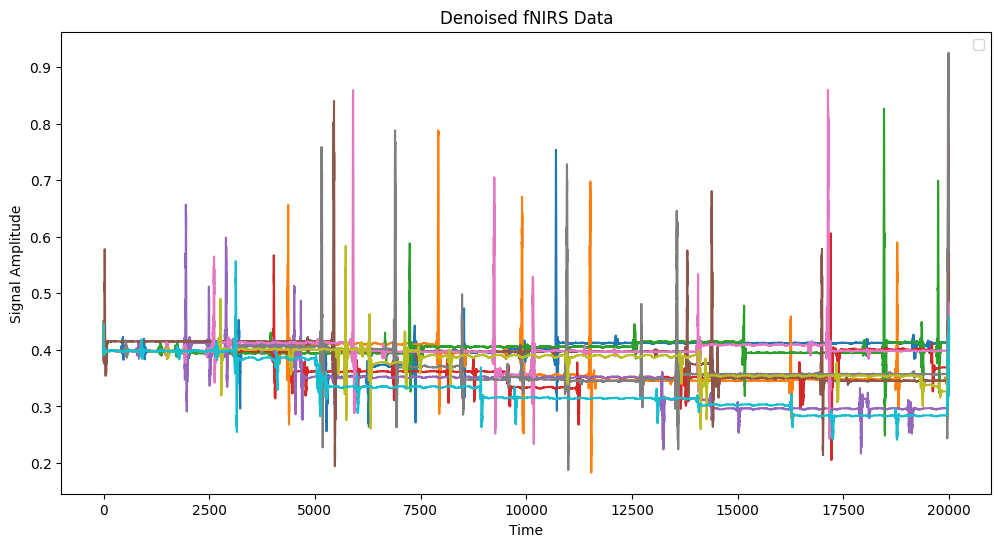

In [ ]:
# Plot Y_pred values clearly
plt.figure(figsize=(12, 6))
for i in range(min(len(Y_pred), 56)):  # Plot up to 3 examples
    plt.plot(Y_pred[i])

plt.title('Denoised fNIRS Data')
plt.xlabel('Time')
plt.ylabel('Signal Amplitude')
plt.legend(loc='upper right')

plt.show()

In [ ]:
print(Y_pred.shape)

(10, 20000, 1)


In [ ]:
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm
# Calculate MSE and RSSE
mse = mean_squared_error(Y_val.flatten(), Y_pred.flatten())
rsse = norm(Y_val.flatten() - Y_pred.flatten(), 2)

print(f"MSE: {mse}")
print(f"RSSE: {rsse}")

MSE: 0.1432160395580374
RSSE: 169.24304390907025


In [ ]:
import os
def process_snirf_data(base_dir):
    # List to store all participants' data
    all_data = []

    # Loop over each directory in the base directory
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)

        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if file_name.endswith('.snirf'):
                    file_path = os.path.join(folder_path, file_name)
                    # Read the SNIRF file
                    raw = mne.io.read_raw_snirf(file_path, preload=True)
                    # Convert to optical density
                    raw_od = mne.preprocessing.nirs.optical_density(raw)
                            # Convert to haemoglobin concentration
                    raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od)
                    snirf_numpy = raw_haemo.get_data()

                    # Convert raw data to NumPy array and store it
                    all_data.append(snirf_numpy)

    return all_data

# Define the base directory where the folders are located
base_dir = '/content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron'

# Process the SNIRF data
snirf_data_list = process_snirf_data(base_dir)

# Optionally, concatenate all data into a single NumPy array if needed
data_snirf_numpy = np.concatenate(snirf_data_list, axis=1)

# Print shape of the combined data to verify
print(data_snirf_numpy.shape)

Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6114/run1.snirf
Reading 0 ... 8674  =      0.000 ...   346.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6114/run2.snirf
Reading 0 ... 8549  =      0.000 ...   341.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6114/run3.snirf
Reading 0 ... 8674  =      0.000 ...   346.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6112/run1.snirf
Reading 0 ... 8699  =      0.000 ...   347.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6112/run2.snirf
Reading 0 ... 8549  =      0.000 ...   341.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6112/run3.snirf


<ipython-input-12-0e66a64c059e>:17: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(raw)
/usr/local/lib/python3.10/dist-packages/mne/preprocessing/nirs/_optical_density.py:52: RuntimeWarning: divide by zero encountered in log
  np.log(raw._data[pi], out=raw._data[pi])
<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Reading 0 ... 8649  =      0.000 ...   345.960 secs...
Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6110/run1.snirf


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Reading 0 ... 8624  =      0.000 ...   344.960 secs...
Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6110/run2_part_2.snirf
Reading 0 ... 8500  =      0.000 ...   340.000 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6110/run3.snirf


<ipython-input-12-0e66a64c059e>:17: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(raw)


Reading 0 ... 8674  =      0.000 ...   346.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6110/run2_part_1.snirf
Reading 0 ... 8549  =      0.000 ...   341.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6107/run1.snirf


<ipython-input-12-0e66a64c059e>:17: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(raw)


Reading 0 ... 8749  =      0.000 ...   349.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6107/run2.snirf
Reading 0 ... 8624  =      0.000 ...   344.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6107/run3.snirf
Reading 0 ... 8649  =      0.000 ...   345.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6108/run1.snirf
Reading 0 ... 8724  =      0.000 ...   348.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6108/run2.snirf


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Reading 0 ... 8524  =      0.000 ...   340.960 secs...
Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6108/run3.snirf


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Reading 0 ... 8649  =      0.000 ...   345.960 secs...
Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6109/run1_.snirf
Reading 0 ... 8624  =      0.000 ...   344.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6109/run2.snirf
Reading 0 ... 8474  =      0.000 ...   338.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6109/run3.snirf
Reading 0 ... 8624  =      0.000 ...   344.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6116/run1.snirf
Reading 0 ... 8699  =      0.000 ...   347.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6116/run2.snirf
Reading 0 ... 8524  =      0.000 ...   340.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6116/run3.snirf
Reading 0 ... 8674  =      0.000 ...   346.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6106/run1.snirf
Reading 0 ... 8649  =      0.000 ...   345.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6106/run2.snirf


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Reading 0 ... 8474  =      0.000 ...   338.960 secs...
Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6106/run3.snirf


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Reading 0 ... 8624  =      0.000 ...   344.960 secs...
Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6115/run1.snirf
Reading 0 ... 8699  =      0.000 ...   347.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6115/run2.snirf
Reading 0 ... 8549  =      0.000 ...   341.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6115/run3.snirf
Reading 0 ... 9799  =      0.000 ...   391.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6113/run1.snirf
Reading 0 ... 8724  =      0.000 ...   348.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6113/run2.snirf
Reading 0 ... 8524  =      0.000 ...   340.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6113/run3.snirf
Reading 0 ... 8649  =      0.000 ...   345.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6085/run1.snirf
Reading 0 ... 8699  =      0.000 ...   347.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6085/run2.snirf


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Reading 0 ... 8549  =      0.000 ...   341.960 secs...
Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6085/run3.snirf


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Reading 0 ... 8649  =      0.000 ...   345.960 secs...
Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6084/run1.snirf
Reading 0 ... 8724  =      0.000 ...   348.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6084/run2.snirf
Reading 0 ... 8524  =      0.000 ...   340.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6084/run3.snirf
Reading 0 ... 8649  =      0.000 ...   345.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6083/run1.snirf
Reading 0 ... 8674  =      0.000 ...   346.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6083/run2.snirf
Reading 0 ... 8524  =      0.000 ...   340.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6083/run3.snirf
Reading 0 ... 8674  =      0.000 ...   346.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6091/run1.snirf


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Reading 0 ... 8674  =      0.000 ...   346.960 secs...
Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6091/run2.snirf
Reading 0 ... 8524  =      0.000 ...   340.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6091/run3.snirf
Reading 0 ... 8649  =      0.000 ...   345.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6086/run1.snirf
Reading 0 ... 8699  =      0.000 ...   347.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6086/run2.snirf
Reading 0 ... 8674  =      0.000 ...   346.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6086/run3.snirf
Reading 0 ... 8799  =      0.000 ...   351.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6101/run1.snirf
Reading 0 ... 8699  =      0.000 ...   347.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6101/run2.snirf
Reading 0 ... 8474  =      0.000 ...   338.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6101/run3.snirf


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Reading 0 ... 8624  =      0.000 ...   344.960 secs...
Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6089/run1.snirf


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Reading 0 ... 8699  =      0.000 ...   347.960 secs...
Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6089/run2.snirf
Reading 0 ... 8499  =      0.000 ...   339.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6089/run3.snirf
Reading 0 ... 8649  =      0.000 ...   345.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6090/run1.snirf
Reading 0 ... 8699  =      0.000 ...   347.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6090/run2.snirf
Reading 0 ... 8524  =      0.000 ...   340.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6090/run3.snirf
Reading 0 ... 8649  =      0.000 ...   345.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6087/run1.snirf
Reading 0 ... 8699  =      0.000 ...   347.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6087/run2.snirf
Reading 0 ... 8674  =      0.000 ...   346.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6087/run3.snirf


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Reading 0 ... 8649  =      0.000 ...   345.960 secs...
Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6105/run1.snirf


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Reading 0 ... 8674  =      0.000 ...   346.960 secs...
Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6105/run2.snirf
Reading 0 ... 8449  =      0.000 ...   337.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6105/run3.snirf
Reading 0 ... 8624  =      0.000 ...   344.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6082/run1.snirf
Reading 0 ... 8674  =      0.000 ...   346.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6082/run2.snirf
Reading 0 ... 8499  =      0.000 ...   339.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


Loading /content/drive/MyDrive/DATA_MotorNeuron (1)/DATA_MotorNeuron/SUBJID_6082/run3.snirf
Reading 0 ... 8649  =      0.000 ...   345.960 secs...


<ipython-input-12-0e66a64c059e>:15: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw = mne.io.read_raw_snirf(file_path, preload=True)


(120, 553226)


17289/17289 [==============================] - 287s 17ms/step


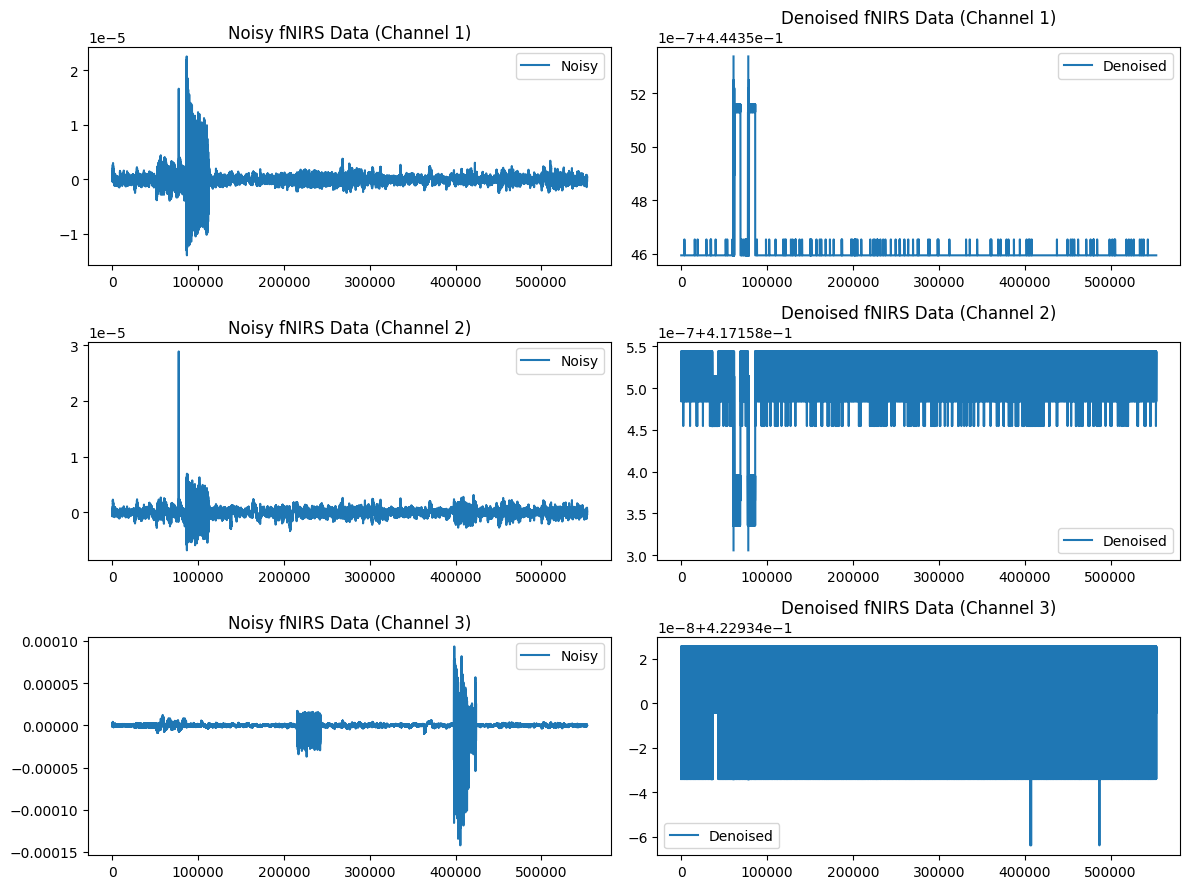

In [ ]:
import mne
from mne.datasets import fnirs_motor
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K



# Custom Loss Functions
def mse_loss(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

def total_variation_loss(y_pred):
    return K.mean(K.square(y_pred - K.mean(y_pred)))

def std_loss(y_pred, m, N_std):
    diffs = y_pred[:, :-1] - y_pred[:, 1:]
    std_diffs = K.std(diffs, axis=-1)
    mask = K.greater(std_diffs, m)
    return K.sum(K.switch(mask, std_diffs, K.zeros_like(std_diffs))) / N_std

def amp_loss(y_pred, C_amp, N_amp):
    diffs = y_pred[:, :-1] - y_pred[:, 1:]
    amp_diffs = K.abs(diffs)
    mask = K.greater(amp_diffs, C_amp)
    return K.sum(K.switch(mask, amp_diffs, K.zeros_like(amp_diffs))) / N_amp

def combined_loss(y_true, y_pred, theta1=1, theta2=1, theta3=10, m=1, N_std=1, C_amp=1, N_amp=1):
    Lmse = mse_loss(y_true, y_pred)
    Lvar = total_variation_loss(y_pred)
    Lstd = std_loss(y_pred, m, N_std)
    Lamp = amp_loss(y_pred, C_amp, N_amp)
    return Lmse + theta1 * Lvar + theta2 * Lstd + theta3 * Lamp

# Load the pre-trained model
custom_objects = {
    'combined_loss': lambda y_true, y_pred: combined_loss(y_true, y_pred, m=1, N_std=1, C_amp=1, N_amp=1),
    'mse_loss': mse_loss,
    'total_variation_loss': total_variation_loss,
    'std_loss': std_loss,
    'amp_loss': amp_loss
}



# Process and retrieve noisy data
noisy_data = data_snirf_numpy  # Shape (56, 23239)

# Reshape the data to match the input shape of the model
X_test = noisy_data[..., np.newaxis]  # Shape (56, 23239, 1)

# Swap axes to match (num_samples, num_channels, 1)
X_test = np.swapaxes(X_test, 0, 1)  # Shape (23239, 56, 1)

# Predict denoised data
Y_denoised = dae_model.predict(X_test)

# Plot examples of noisy and denoised data
num_examples = 3
fig, axes = plt.subplots(num_examples, 2, figsize=(12, 9))

for i in range(num_examples):
    axes[i, 0].plot(X_test[:, i, 0], label='Noisy')
    axes[i, 0].set_title(f'Noisy fNIRS Data (Channel {i+1})')
    axes[i, 0].legend()

    axes[i, 1].plot(Y_denoised[:, i, 0], label='Denoised')
    axes[i, 1].set_title(f'Denoised fNIRS Data (Channel {i+1})')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


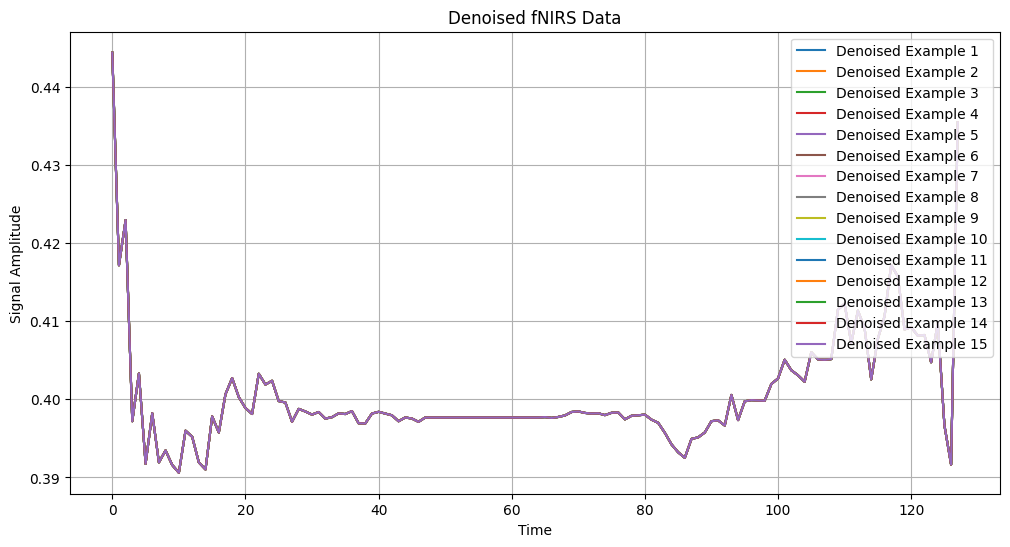

In [ ]:
# Plot Y_pred values clearly
plt.figure(figsize=(12, 6))
for i in range(min(len(Y_denoised), 15)):  # Plot up to 3 examples
    plt.plot(Y_denoised[i], label=f'Denoised Example {i+1}')

plt.title('Denoised fNIRS Data')
plt.xlabel('Time')
plt.ylabel('Signal Amplitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
# Assuming new_clean_data and new_noisy_data are loaded and defined
new_clean_hrf_2d, new_noisy_hrf_2d = new_clean_data, new_noisy_data

# Reshape the data
X_new = new_noisy_hrf_2d[..., np.newaxis]
Y_new = new_clean_hrf_2d[..., np.newaxis]

# Split the data
X_train_new, X_val_new, Y_train_new, Y_val_new = train_test_split(X_new, Y_new, test_size=0.2, random_state=42)


NameError: name 'new_clean_data' is not defined

In [ ]:
# Compile the model if needed
dae_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, m=1, N_std=1, C_amp=1, N_amp=1))

In [ ]:
# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with the new data and store the history
history_new = dae_model.fit(X_train_new, Y_train_new, epochs=50, batch_size=64, validation_data=(X_val_new, Y_val_new), callbacks=[early_stopping])

# Print training and validation loss for each epoch
for epoch in range(len(history_new.history['loss'])):
    print(f"Epoch {epoch + 1}:")
    print(f"  Training Loss: {history_new.history['loss'][epoch]}")
    print(f"  Validation Loss: {history_new.history['val_loss'][epoch]}")

# Plot training & validation loss values for the new training
plt.figure(figsize=(10, 5))
plt.plot(history_new.history['loss'], label='Training Loss')
plt.plot(history_new.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (New Training)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Predict denoised data on new validation set
Y_pred_new = dae_model.predict(X_val_new)

# Plot examples of noisy and denoised data from new dataset
num_examples = 3
fig, axes = plt.subplots(num_examples, 2, figsize=(12, 9))

for i in range(num_examples):
    axes[i, 0].plot(X_val_new[i].squeeze(), label='Noisy')
    axes[i, 0].set_title(f'Noisy fNIRS Data (Example {i+1})')
    axes[i, 0].legend()

    axes[i, 1].plot(Y_val_new[i].squeeze(), label='Clean', linestyle='dashed')
    axes[i, 1].plot(Y_pred_new[i].squeeze(), label='Denoised')
    axes[i, 1].set_title(f'Denoised fNIRS Data (Example {i+1})')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

# Save the newly trained model and new training history
dae_model.save('dae_model.h5')
np.save('history.npy', history.history)
